### II. Global sensitivity analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import pprint
import numpy as np
from plotting_sobol import (plot_sobol_indices, plot_scores)

from specify import specify_levers

from __future__ import (unicode_literals, print_function, absolute_import,
                        division)
import time

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench import save_results
from ema_workbench import load_results

ema_logging.log_to_stderr(ema_logging.INFO)
# ema_logging.log_to_stderr(ema_logging.DEBUG)

<Logger EMA (DEBUG)>

### 1. Define the problem and policies

In [2]:
# Specify the problem
# 3 obj PF
from problem_formulation import get_model_for_problem_formulation
n_outcomes = 3
dike_model = get_model_for_problem_formulation(1)

# # 8 obj PF
# from problem_formulation_new_version import get_model_for_problem_formulation
# n_outcomes = 8
# dike_model = get_model_for_problem_formulation(4)

# Specify the policies
n_policies = 4
policy0 = Policy('policy_0', **specify_levers(0,0,0,0,0,0,0,0,0,0,0)) # DO NOTHING
policy1 = Policy('policy_1', **specify_levers(10,0,10,0,0,0,0,0,0,0,0)) # DO DIKES at A1, A3
policy2 = Policy('policy_2', **specify_levers(10,10,10,0,10,0,0,0,0,0,0)) # DO DIKES at A1, A2, A3, A5
policy3 = Policy('policy_3', **specify_levers(10,10,10,10,10,1,1,1,1,1,4)) # DO EVERYTHING

# Specify reference scenarios

C:\Users\Mikhail\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
[MainProcess/INFO] model initialized


### OLS

In [3]:
# import statsmodels.api as sm

In [4]:
# X = pd.DataFrame(experiments).drop(['model'], inplace=False, axis=1)
# X['policy'] = policiesW
# X = X[X['policy'] == 0]

# y = outcomes['Expected Number of Deaths'][:int(n_scenarios)]

In [5]:
# X_0 = sm.add_constant(X)
# est = sm.OLS(y, X_0.astype(float)).fit()

# print(est.summary())
# print(est.params)

### 2. Sobol's scores

In [6]:
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

#### 2.1 Run over the uncertainties

In [7]:
# problem = get_SALib_problem(dike_model.uncertainties)
# n_scenarios = 250
# start = time.time()
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     experiments, outcomes = evaluator.perform_experiments(scenarios = n_scenarios,
#                                                       W    policies = [policy0, policy1, policy2, policy3], 
#                                                           uncertainty_sampling = SOBOL)
# end = time.time()
# print('Sobol time is ' + str(round((end - start)/60)) + ' mintues')

In [8]:
# results = (experiments, outcomes)
# save_results(results, 'Sobol_results_uncertainties_5Ksc_4pol.tar.gz')

#### 1.2 Run over the levers

In [9]:
# problem = get_SALib_problem(dike_model.levers)
# start = time.time()
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     experiments, outcomes = evaluator.perform_experiments(scenarios = reference_scenario,
#                                                           policies = 300,  
#                                                           levers_sampling = SOBOL)
# end = time.time()
# print('Sobol time is ' + str(round((end - start)/60)) + ' mintues')

In [10]:
# results = (experiments, outcomes)
# save_results(results, 'Sobol_results_levers.tar.gz')

In [11]:
results = load_results('Sobol_results_uncertainties_150s_4pol_3obj.tar.gz')
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\Mikhail\Python projects\Model-based decision-making\final assignment\Sobol_results_uncertainties_150s_4pol_3obj.tar.gz


#### 1.3 Preprocess data

In [12]:
sobol_multiplier = 36
n_scenarios = 150
# n_scenarios = pd.DataFrame(experiments).shape[0] / 4 / 36

In [13]:
#
experiments, outcomes = results
policies = np.empty([len(experiments), 1])
k = 0
l = n_scenarios * sobol_multiplier
for i in range (len(experiments)) : 
    policies[i] = k
    if (i == l - 1) : 
        k = k + 1
        l = l + n_scenarios * sobol_multiplier
policies = policies.astype(int)

data = pd.DataFrame.from_dict(outcomes)
data['Policy'] = policies

In [14]:
outcomes_names = list(dike_model.outcomes.keys())
n_outcomes = len(outcomes_names)
len_outcomes = int(len(experiments) / n_policies)

outcomes_tup = ()

for i in range (0, n_outcomes) : 
    outcome_np = np.empty([len_outcomes, n_policies])
    for j in range(0, n_policies) : 
        outcome_np[:, j] = pd.DataFrame(data[data.Policy == j][outcomes_names[i]]).reset_index(drop = True).values[:, 0]
    outcomes_tup = outcomes_tup + (outcome_np,)

#### 1.4 Calculate scores

In [15]:
# # Over the levers
# problem = get_SALib_problem(dike_model.levers)

In [16]:
# Calculate scores
# With the k value in outcomes_tup[k][:, i] you can explore various outcomes 
# Currently k = 2, so we're investigating Expected Number of Deaths
problem = get_SALib_problem(dike_model.uncertainties)
scores = []
for i in range(0, n_policies) : 
    scores.append(sobol.analyze(problem, outcomes_tup[0][:, i], calc_second_order=True))

In [17]:
# # TODO: check it again, now scores_tup is the same for any policy
# # Over uncertainties
# problem = get_SALib_problem(dike_model.uncertainties)
# scores_tup = () # 1 * n_policies
# scores = [] # 1 * n_outcomes
# # outcomes_tup 1 * n_outcomes : (n_experiments * n_policies)

# for i in range(0, n_policies) : 
#     for j in range(0, n_outcomes) : 
#         scores.append(sobol.analyze(problem, outcomes_tup[j][:,i], calc_second_order=True))
#     scores_tup = scores_tup + (scores, )

#### 1.5 Plotting

#### Bar charts

In [18]:
# How to read scores_tup?
# For example 
# scores_tup[0][0] contains effects of uncertainties on 1st outcome - Expected Annual Damage under 1st policy - DO NOTHING

In [19]:
# # Show effects of uncertainties on 3d outcome - Expected Number of Deaths under all 4 policies
# # fig = plot_scores(scores_tup[][0], problem)
# for i in range(0, n_policies) : 
#     fig = plot_scores(scores_tup[i][1], problem)
#     fig.axes.append(fig)
# plt.show()

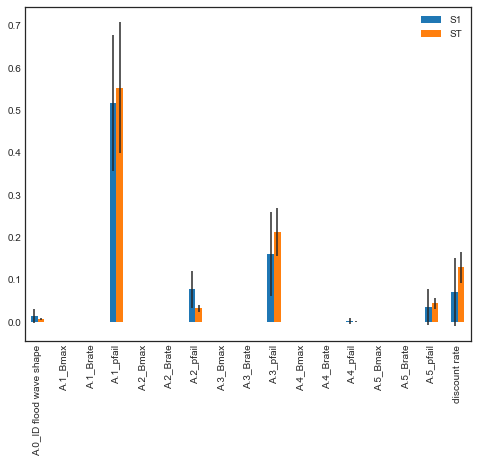

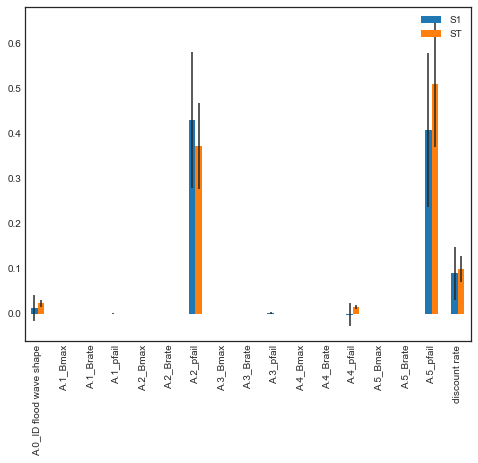

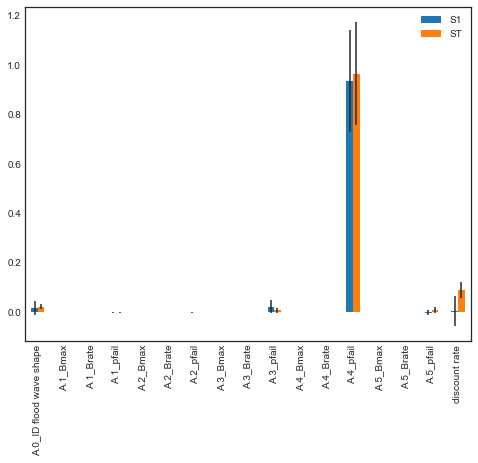

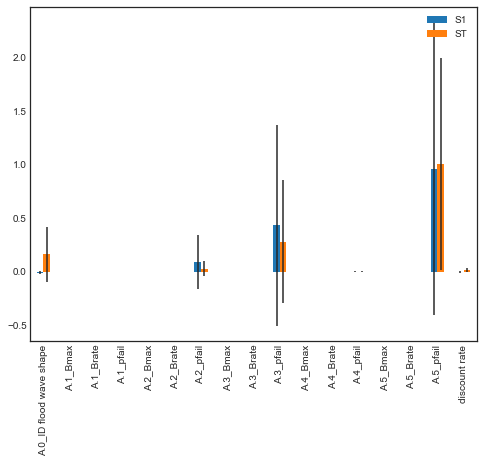

In [20]:
fig = plot_scores(scores[0], problem)
for i in range(1, n_policies) : 
    figi = plot_scores(scores[i], problem)
    figi.axes.append(fig)
plt.show()

#### Radial plots

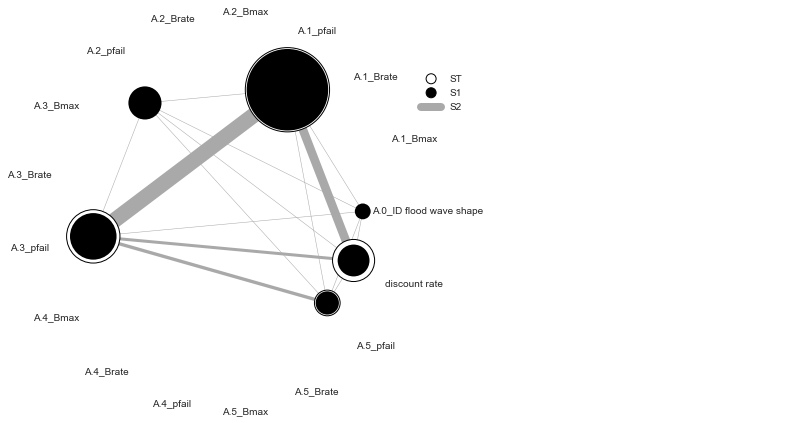

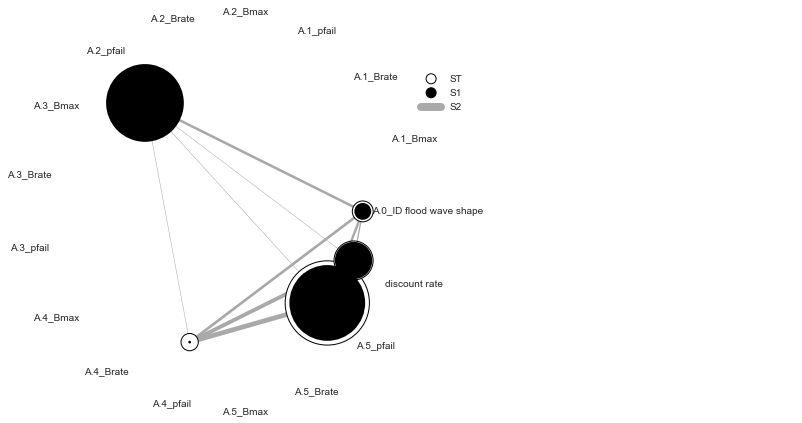

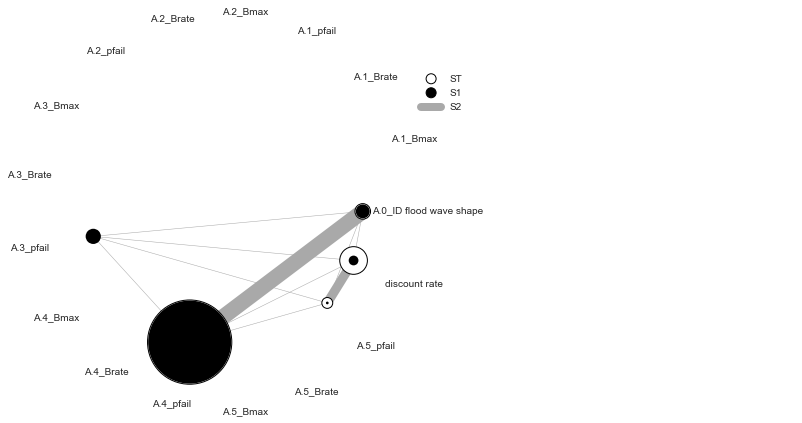

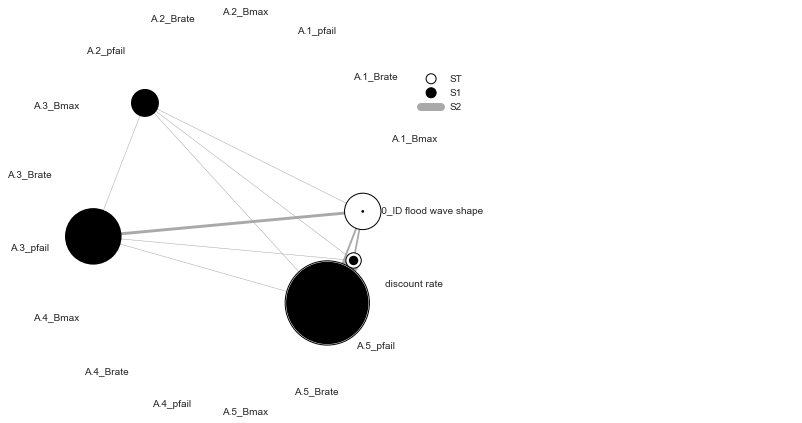

In [21]:
fig = plot_sobol_indices(scores[0], problem, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)

for i in range(1, n_policies) : 
    figi = plot_sobol_indices(scores[i], problem, criterion='ST', threshold=0.005)
    figi.set_size_inches(7,7)
    figi.axes.append(fig)

plt.show()

### 2. Feature scoring

In [22]:
import numpy.lib.recfunctions as rf
from ema_workbench.analysis import feature_scoring

C:\Users\Mikhail\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Mikhail\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


#### Preprocess results

In [23]:
experiments, outcomes = results
experiments = rf.drop_fields(experiments, 
                             drop_names=['model', 'A.1_DikeIncrease', 'A.2_DikeIncrease', 
                                         'A.3_DikeIncrease', 'A.4_DikeIncrease', 'A.5_DikeIncrease', 
                                         '0_RfR', '1_RfR', '2_RfR', 
                                         '3_RfR', '4_RfR', 'EWS_DaysToThreat', ], asrecarray=True)

In [24]:
df = pd.DataFrame(experiments)
X_tup = ()
for i in range(0, n_policies) : 
    X = df[df.policy == 'policy_' + str(i)].to_records(index=False)
    X = rf.drop_fields(X, drop_names=['policy'], asrecarray=True)
    X_tup = X_tup + (X,)

In [25]:
y_tup = ()
n_experiments = n_scenarios * 36
outcomes_len = n_experiments / n_policies
k = n_experiments
l = 0

for i in range(0, n_policies) : 
    y_tup = y_tup + (pd.DataFrame(outcomes)[l:k].reset_index(drop=True), )
    l = k
    k = k + n_experiments

#### Calculate scores

In [26]:
scores_tup = ()
for i in range(0, n_policies) : 
    scores_tup = scores_tup + (feature_scoring.get_feature_scores_all(X_tup[i], y_tup[i]),)

C:\Users\Mikhail\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
C:\Users\Mikhail\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
C:\Users\Mikhail\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass

#### Visulize results

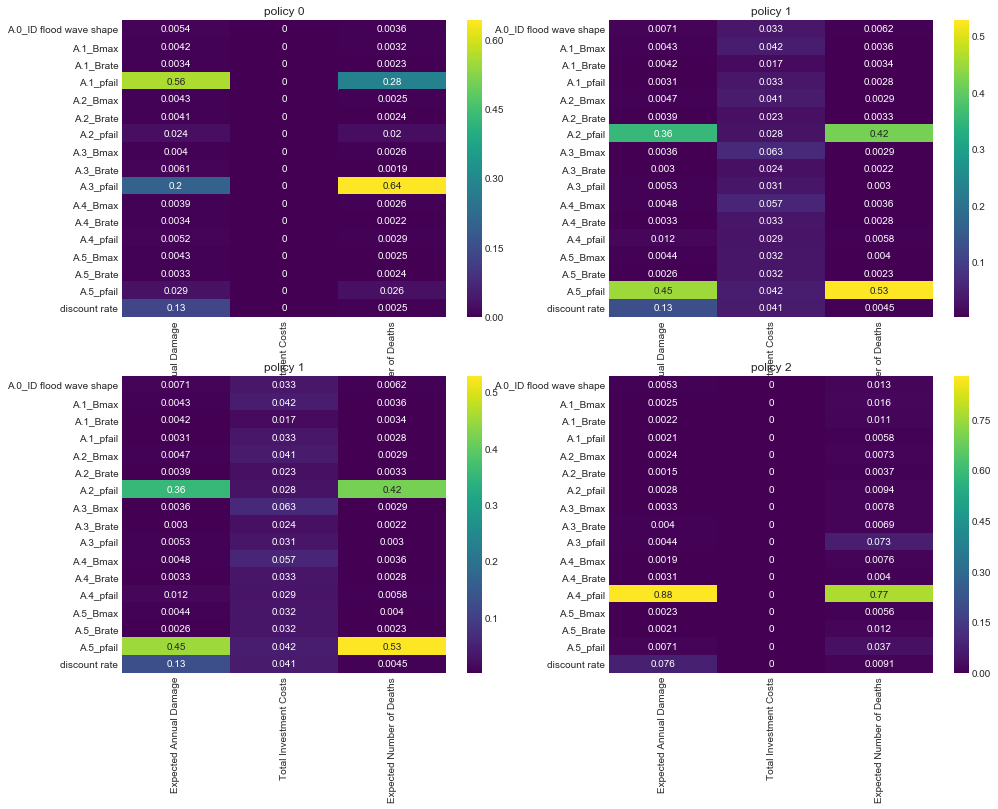

In [27]:
fig, axs = plt.subplots(figsize=[16,12],ncols=2,nrows=2)
for i in range(0, int(n_policies / 2)) : 
    for j in range(0, int(n_policies / 2)) : 
        ax = sns.heatmap(scores_tup[i + j], cmap='viridis', annot=True, ax=axs[i,j]).set_title('policy ' + str(i + j))